# Sports scheduling

In sports scheduling we usually have a bunch of games which are basically tasks requiring the two competing teams and a field as resources, so lets formulate this:

INFO: execution time for solving mip (sec) = 0.35045933723449707
INFO: objective = None


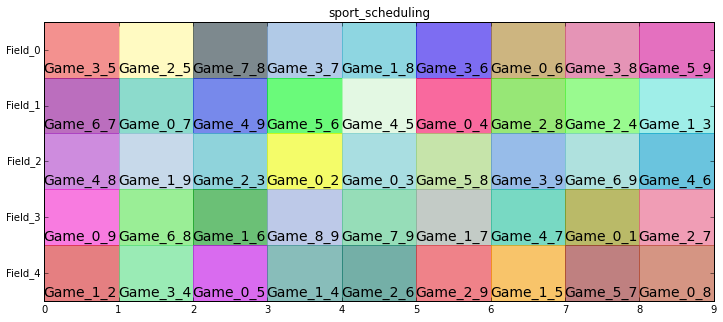

In [13]:
from pyschedule import Scenario, solvers, plotters, OR

n_teams = 10 # Number of teams
n_fields = int(n_teams/2) # Num of fields
n_rounds = n_teams-1 # Number of rounds

# Create scenario
S = Scenario('sport_scheduling',horizon=n_rounds)

# Game tasks
Games = { (i,j) : S.Task('Game_%i_%i'%(i,j)) for i in range(n_teams) 
                                             for j in range(n_teams) if i < j }

# Team and field resources
Teams =  [ S.Resource('Team_%i'%i) for i in range(n_teams) ]
Fields = [ S.Resource('Field_%i'%i) for i in range(n_fields) ]

# Resource requirements
for i,j in Games :
    S += Games[i,j] % [Teams[i], Teams[j]]
    S += Games[i,j] % OR([ Fields[k] for k in range(n_fields) ])

solvers.pulp.solve_unit(S,msg=1)
%matplotlib inline
plotters.matplotlib.plot(S,hide_resources=Teams,fig_size=(12,5))

However, the fields might be quite different, and so it would be unfair if some team needs to play more than twice on any one. We can avoid this by assigning each game a parameter for each team that plays this game and set it to one (here we simply use integers as parameters, this could also be some string in case of more parameters). Finally, we restrict any team parameter to two on any field:

INFO: execution time for solving mip (sec) = 8.067422151565552
INFO: objective = None


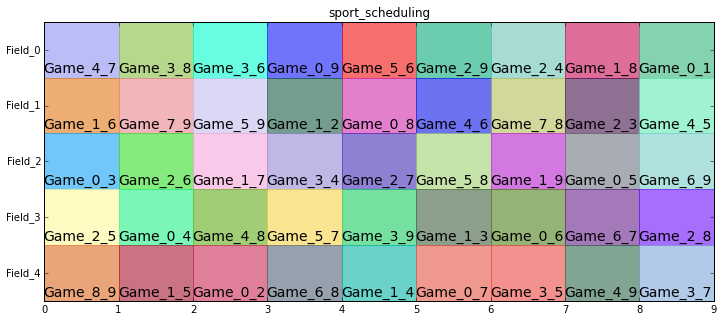

In [14]:
# Teams in games as task parameters
for i,j in Games :
    Games[i,j][i] = 1
    Games[i,j][j] = 1

# Each team at most two times per field
for j in range(n_fields):
    for i in range(n_teams) :
        S += Fields[j][i] <= 2
        
solvers.pulp.solve_unit(S,msg=1)
plotters.matplotlib.plot(S,hide_resources=Teams,fig_size=(12,5))

Sometimes we want to fix some games to specific rounds or fields. Here we fix all games in the middle round (n_fields-1):

INFO: execution time for solving mip (sec) = 3.824254274368286
INFO: objective = None


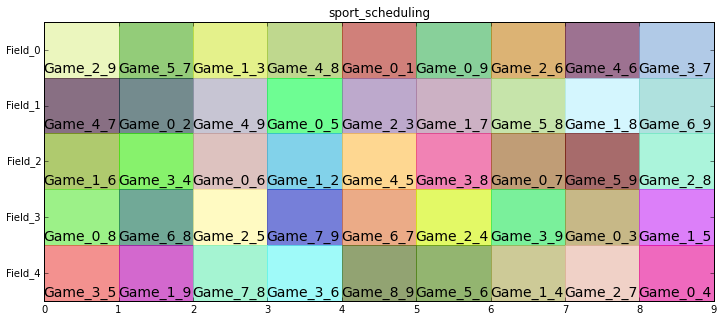

In [ ]:
for i in range(n_fields):
    # Start in the middle round
    S += Games[2*i,2*i+1] >= n_fields-1
    # Restrict to specific field
    S += Games[2*i,2*i+1] % Fields[i]

solvers.pulp.solve_unit(S,msg=1)
plotters.matplotlib.plot(S,hide_resources=Teams,fig_size=(12,5))

If some team plays in the middle round on some field, it would be nice if it does not play in any other round on this field. It is not entirely clear if this is possible, so lets try:

In [ ]:
for i in range(n_fields):
    # Team at most once overall
    S += Fields[i][2*i] <= 1
    S += Fields[i][2*i+1] <= 1
    
solvers.pulp.solve_unit(S,msg=1)
plotters.matplotlib.plot(S,hide_resources=Teams,fig_size=(12,5))

Works! But takes quite some time to compute